# Spiral inductor

This example shows how to use PyAEDT to create a spiral inductor, solve it, and plot results.

Keywords: **HFSS**, **spiral**, **inductance**, **output variable**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch HFSS

Create an HFSS design and change the units to microns.

In [5]:
project_name = os.path.join(temp_folder.name, "spiral.aedt")
hfss = ansys.aedt.core.Hfss(
    project=project_name,
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    design="A1",
    new_desktop=True,
    solution_type="Modal",
)
hfss.modeler.model_units = "um"

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_72359537-dd31-4394-8a5d-71032f4b1137.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 64242


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 5768.


PyAEDT INFO: Project spiral has been created.


PyAEDT INFO: Added design 'A1' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


## Define variables

Define input variables. You can use the values that follow or edit
them.

In [6]:
rin = 10
width = 2
spacing = 1
thickness = 1
Np = 8
Nr = 10
gap = 3
hfss["Tsub"] = "6" + hfss.modeler.model_units

## Standardize polyline

Define a function that creates a polyline using the ``create_line()`` method. This
function creates a polyline having a fixed width, thickness, and material.

In [7]:
def create_line(pts):
    hfss.modeler.create_polyline(
        pts,
        xsection_type="Rectangle",
        xsection_width=width,
        xsection_height=thickness,
        material="copper",
    )

## Create spiral inductor

Create the spiral inductor. This spiral inductor is not
parametric, but you could parametrize it later.

In [8]:
ind = hfss.modeler.create_spiral(
    internal_radius=rin,
    width=width,
    spacing=spacing,
    turns=Nr,
    faces=Np,
    thickness=thickness,
    material="copper",
    name="Inductor1",
)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


## Center return path

Center the return path.

In [9]:
x0, y0, z0 = ind.points[0]
x1, y1, z1 = ind.points[-1]
create_line([(x0 - width / 2, y0, -gap), (abs(x1) + 5, y0, -gap)])
hfss.modeler.create_box(
    [x0 - width / 2, y0 - width / 2, -gap - thickness / 2],
    [width, width, gap + thickness],
    matname="copper",
)

PyAEDT WARNING: Argument `matname` is deprecated for method `create_box`; use `material` instead.


Create port 1.

In [10]:
hfss.modeler.create_rectangle(
    orientation=ansys.aedt.core.constants.PLANE.YZ,
    origin=[abs(x1) + 5, y0 - width / 2, -gap - thickness / 2],
    sizes=[width, "-Tsub+{}{}".format(gap, hfss.modeler.model_units)],
    name="port1",
)
hfss.lumped_port(assignment="port1", integration_line=ansys.aedt.core.constants.AXIS.Z)

PyAEDT INFO: Boundary Lumped Port Port_5DUPQ8 has been correctly created.


Create port 2.

In [11]:
create_line([(x1 + width / 2, y1, 0), (x1 - 5, y1, 0)])
hfss.modeler.create_rectangle(
    ansys.aedt.core.constants.PLANE.YZ,
    [x1 - 5, y1 - width / 2, -thickness / 2],
    [width, "-Tsub"],
    name="port2",
)
hfss.lumped_port(assignment="port2", integration_line=ansys.aedt.core.constants.AXIS.Z)

PyAEDT INFO: Boundary Lumped Port Port_76FAR3 has been correctly created.


Create the silicon substrate and the ground plane.

In [12]:
hfss.modeler.create_box(
    [x1 - 20, x1 - 20, "-Tsub-{}{}/2".format(thickness, hfss.modeler.model_units)],
    [-2 * x1 + 40, -2 * x1 + 40, "Tsub"],
    material="silicon",
)

hfss.modeler.create_box(
    [x1 - 20, x1 - 20, "-Tsub-{}{}/2".format(thickness, hfss.modeler.model_units)],
    [-2 * x1 + 40, -2 * x1 + 40, -0.1],
    material="PEC",
)

## Set up model

Create the air box and radiation boundary condition.

In [13]:
box = hfss.modeler.create_box(
    [
        x1 - 20,
        x1 - 20,
        "-Tsub-{}{}/2 - 0.1{}".format(
            thickness, hfss.modeler.model_units, hfss.modeler.model_units
        ),
    ],
    [-2 * x1 + 40, -2 * x1 + 40, 100],
    name="airbox",
    material="air",
)

hfss.assign_radiation_boundary_to_objects("airbox")

PyAEDT INFO: Boundary Radiation Rad__62A8YT has been correctly created.


Assign a material override that allows object intersections,
assigning conductors higher priority than insulators.

In [14]:
hfss.change_material_override()

PyAEDT INFO: Enabling Material Override


True

View the model.

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpcwarhz1h.ansys/spiral.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpcwarhz1h.ansys/spiral.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


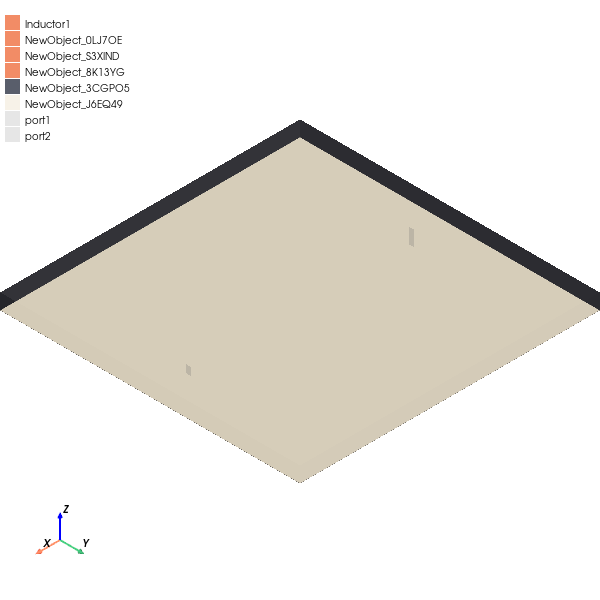

In [15]:
hfss.plot(
    show=False,
    output_file=os.path.join(hfss.working_directory, "Image.jpg"),
    plot_air_objects=False,
)

## Generate the solution

Create the setup, including a frequency sweep. Then, solve the project.

In [16]:
setup1 = hfss.create_setup(name="setup1")
setup1.props["Frequency"] = "10GHz"
hfss.create_linear_count_sweep(
    setup="setup1",
    units="GHz",
    start_frequency=1e-3,
    stop_frequency=50,
    num_of_freq_points=451,
    sweep_type="Interpolating",
)
hfss.save_project()
hfss.analyze(cores=NUM_CORES)

PyAEDT INFO: Linear count sweep Sweep_UONFG8 has been correctly created.


PyAEDT INFO: Project spiral Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 9.0s


True

## Postprocess

Get report data and use the following formulas to calculate
the inductance and quality factor.

In [17]:
L_formula = "1e9*im(1/Y(1,1))/(2*pi*freq)"
Q_formula = "im(Y(1,1))/re(Y(1,1))"

Define the inductance as a postprocessing variable.

In [18]:
hfss.create_output_variable("L", L_formula, solution="setup1 : LastAdaptive")

True

Plot the results using Matplotlib.

PyAEDT INFO: Solution Data Correctly Loaded.


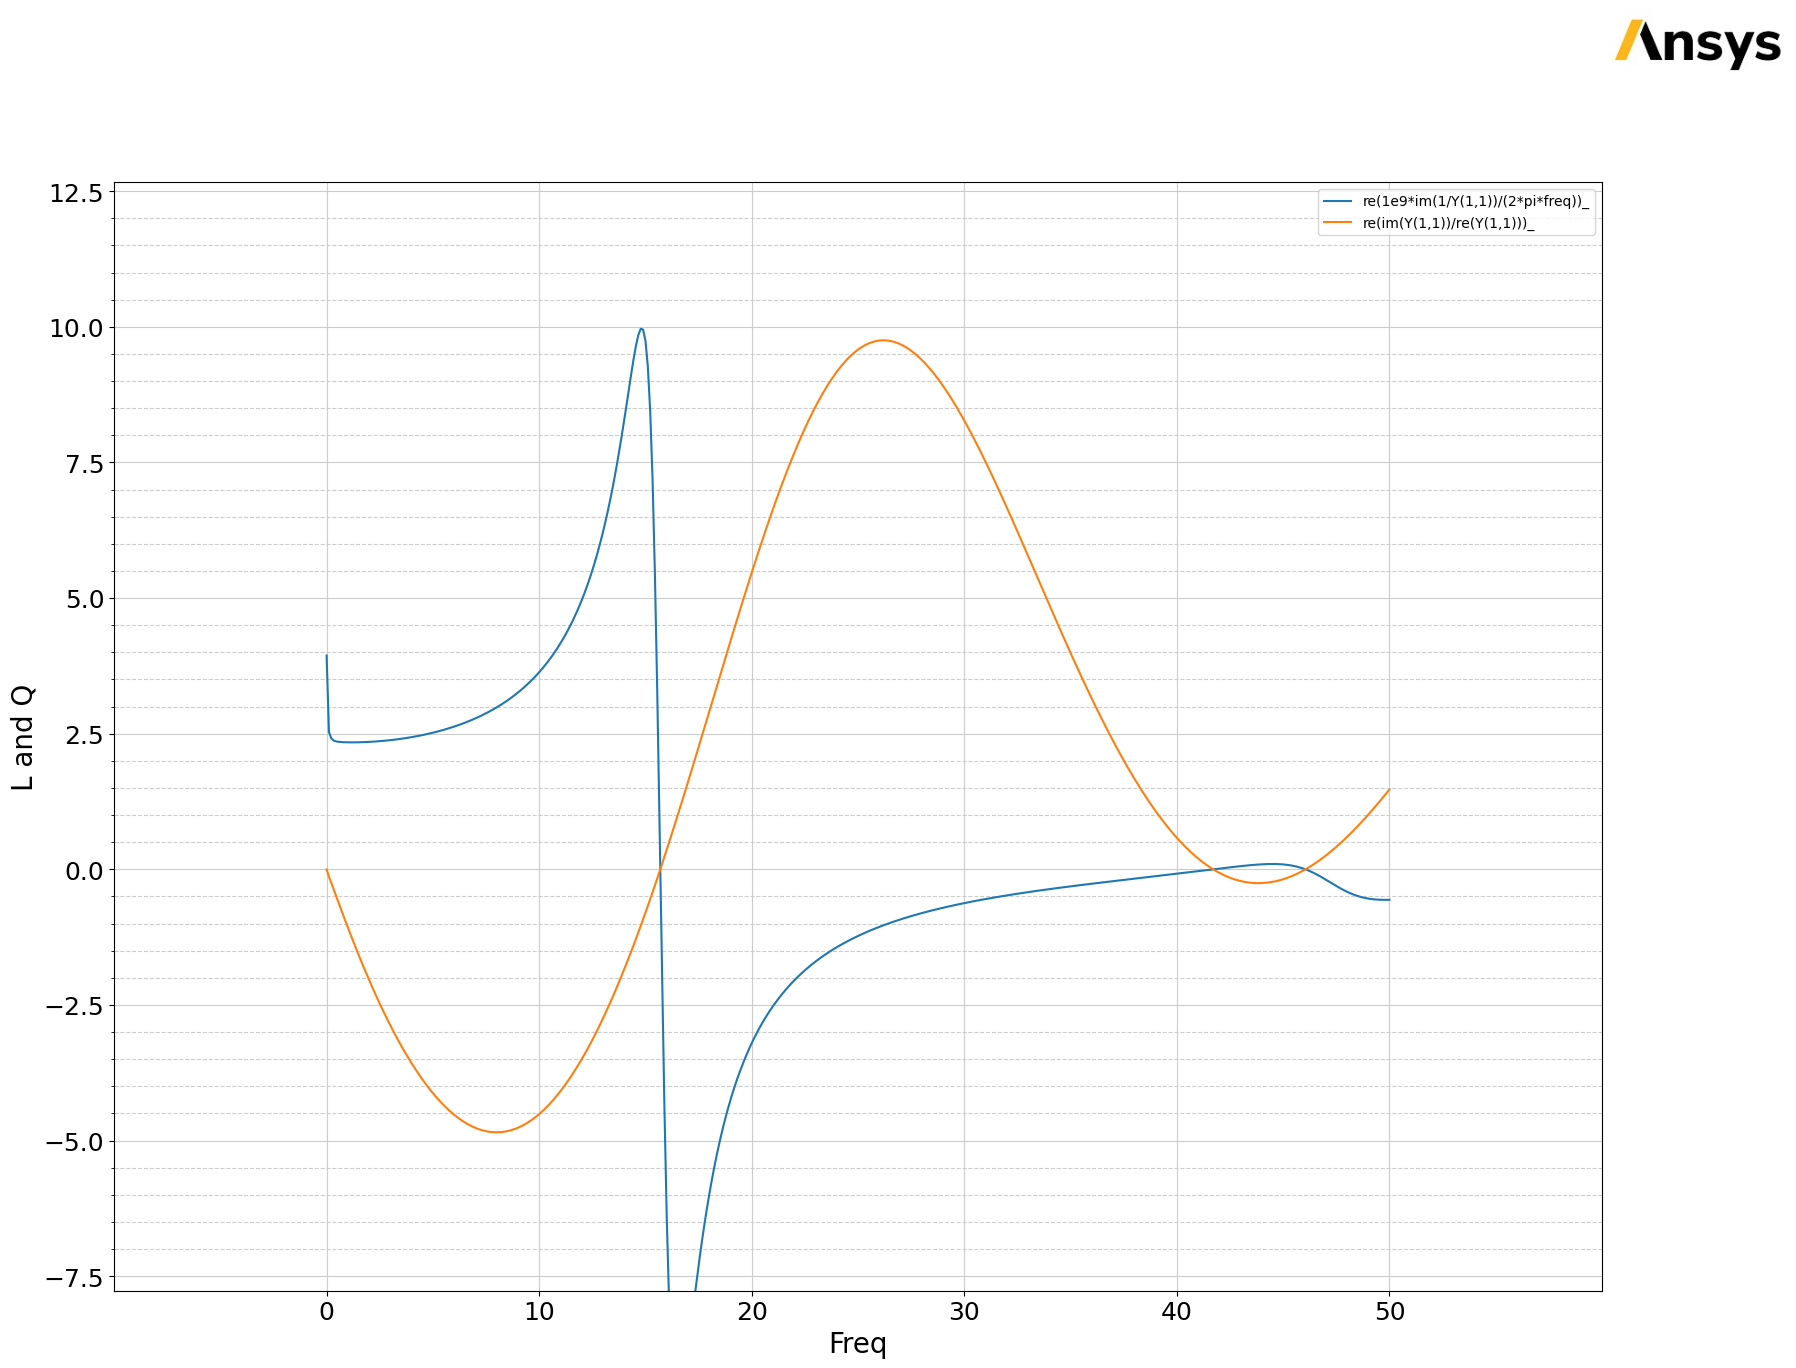

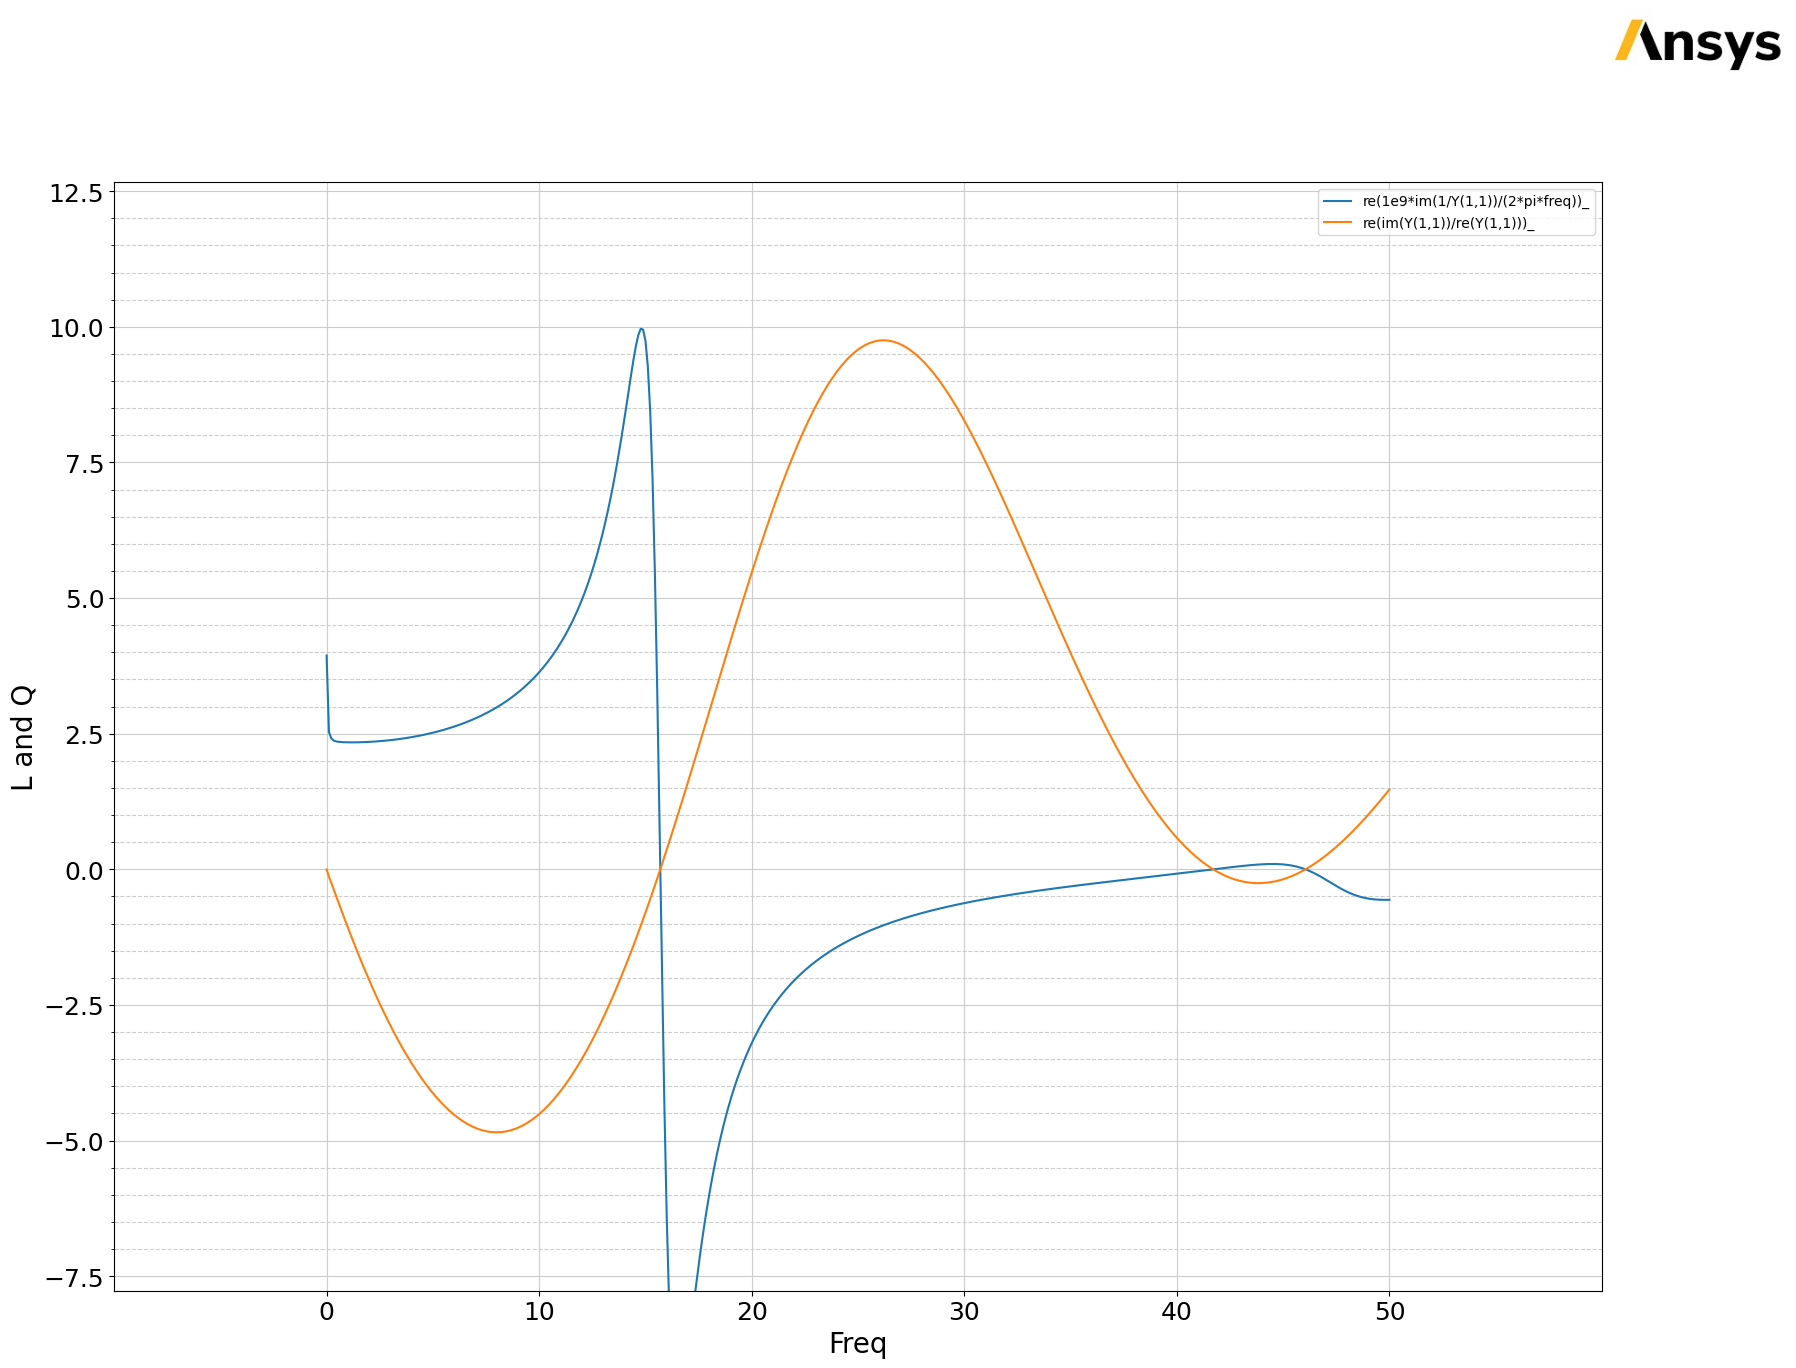

In [19]:
data = hfss.post.get_solution_data([L_formula, Q_formula])
data.plot(
    curves=[L_formula, Q_formula], formula="re", x_label="Freq", y_label="L and Q"
)

Export results to a CSV file

In [20]:
data.export_data_to_csv(os.path.join(hfss.toolkit_directory, "output.csv"))

True

## Save project and close AEDT

Save the project and close AEDT.

In [21]:
hfss.save_project()
hfss.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project spiral Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes
all temporary files, including the project folder.

In [22]:
temp_folder.cleanup()